<a href="https://colab.research.google.com/github/DenisPerez/NN_Tests_DG/blob/main/Experimento1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 1: Estudio de todos los métodos

**Propósito:** Estudiar el desempeño y la velocidad de convergencia basado en epochs de los métodos cíclicos y el método decreciente (propio) combinados con la estrategia de Momentum


> **Nota:** Si se utilizará Google Colab como ambiente para las pruebas, se debe tomar la referencia al repositorio para que la libreta tenga acceso a los archivos que requiere


In [1]:
# !git clone https://github.com/DenisPerez/NN_Tests_DG.git
# %cd NN_Tests_DG
# %ls

Al tener disponible los archivos a referenciar, se realizan las importaciones necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images
from classes import CyclicLRGiselt_Denis

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0) # => importante para replicar los experimentos. Setea la semilla para la generacion de numeros aleatorios

from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
import seaborn as sns

import random

### Extracción del conjunto de datos: MNIST

Este conjundo de datos esta basado en 60.000 imágenes en el conjunto de entrenamiento y 10.000 en el conjunto de prueba de 28x28 píxeles
que representan dígitos del 0 al 9 escritos a mano y es considerado el "Hola Mundo" en el
área de la ciencia de datos. Sin embargo, **10.000  de las muestras del conjunto de entrenamiento serán destinadas al conjunto de validación** con el que se te tomará la precisión en el entrenamiento.

In [3]:
MNIST_PATH = './Dataset/'

In [4]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [5]:
# Segmento para el conjunto de entrenamiento
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

# Segmento para el conjunto de validacion
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

# Segmento para el conjunto de prueba
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

In [6]:
unique, counts = np.unique(y_test, return_counts=True)
class_count = counts.tolist()
print(f"Cantidad de elementos en cada clase: {class_count}")

Cantidad de elementos en cada clase: [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


### Normalización de la muestra

In [7]:
def normalize(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

Se toma la desviación estandar y la media de cada conjunto de datos y se llama a la función *normalize*

In [8]:
# Calculo para el conjunto de entrenamiento
x_mean = x_train.mean()
x_std = x_train.std()
x_train = normalize(x_mean, x_std, x_train)

# Calculo para el conjunto de validación
x_mean = x_val.mean()
x_std = x_val.std()
x_val = normalize(x_mean, x_std, x_val)

# Calculo para el conjunto de prueba
x_mean = x_test.mean()
x_std = x_test.std()
x_test = normalize(x_mean, x_std, x_test)

In [9]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

### Visualización de la muestra

In [10]:
# Dimensiones del conjunto de datos de entrenamiento
x_test.shape

(10000, 784)

In [11]:
# Dimensiones del conjunto de datos de prueba:
y_train.shape

(50000, 1)

In [12]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 8


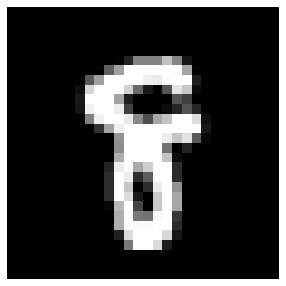

In [13]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Creación de mini lotes

In [14]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, input_layer
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Conversión de arreglo a tensores para todos los conjuntos de datos

In [15]:
# Conversion para el conjunto de entrenamiento
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

# Conversion para el conjunto de validación
x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

# Conversion para el conjunto de prueba
x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

### Habilitar el uso del CPU

Primero se consulta si se tiene la plataforma CUDA disponible para la utilización de los recursos de GPU

In [16]:
torch.cuda.is_available()

True

En caso de no tenerse, se asigna el trabajo de computo al CPU

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Funciones 

### Precisión

In [18]:
# def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
#     num_correct = 0
#     num_total = 0
#     model.eval()
#     model = model.to(device=device)
#     with torch.no_grad():
#         for (xi, yi) in create_minibatches(x, y, mb_size):
#             xi = xi.to(device=device, dtype = torch.float32)
#             yi = yi.to(device=device, dtype = torch.long)
#             scores = model(xi) # mb_size, 10
#             _, pred = scores.max(dim=1) #pred shape (mb_size )
#             num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
#             num_total += pred.size(0)

#             return float(num_correct)/num_total 
        
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)  # mb_size, 10
            _, pred = scores.max(dim=1)  # pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum()  # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
            all_preds.extend(list(pred.cpu().numpy()))
            all_targets.extend(list(yi.squeeze().cpu().numpy()))

    # calculate confusion matrix
    conf_mat = confusion_matrix(all_targets, all_preds)

    return float(num_correct)/num_total, conf_mat

### Find LR

In [19]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, mb_size = 512):
    n = round(len(x_train_tensor) / mb_size)
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    i = 1
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):

        xi = xi.to(device = device, dtype = torch.float32)
        yi = yi.to(device = device, dtype = torch.long)
        scores = model(xi)
        cost = F.cross_entropy(input=scores, target=yi.squeeze())
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == yi).sum()/scores.size(0))
        acc = beta*acc + (1-beta)*acc_.item()
        avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'El modelo diverge apartir de aqui: {i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(avg_acc)
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        optimiser.zero_grad()
        cost.backward()
        optimiser.step()
        #update lr
        print(f'[{i}]cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        i += 1
        
    return log_lrs, losses, accuracies

### Entrenamiento

In [20]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    unregistered = True
    epoch_acc = 0.0
    iter_found = 0
    i = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (i < 5):
        if (epoch_acc >= 0.97 and unregistered):
          iter_found = i
          unregistered = False
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr = optimizer.param_groups[0]['lr']
          lr_list.append(lr)
        i+=1
        epoch_acc, _ = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        # print(f'Epoch: {len(acc_list) - 1}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list, iter_found

### Operaciones en las trazas

In [21]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

In [22]:
def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

In [23]:
def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

## Graficar y validar matriz de confusion

In [24]:
def plot_confusion_matrix(cm):
    labels = np.arange(len(cm))
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', square=True, xticklabels=labels, yticklabels=labels, ax=ax, cbar=True)

    # Formatear los números en el eje x e y sin notación científica
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.show()

def validate_confusion_matrix(cm, num_samples):
    # Verificar si la suma de cada fila de la matriz de confusión es igual a num_samples
    for i, num_sample in enumerate(num_samples):
        assert cm[i,:].sum() == num_sample, f"La suma de la fila {i} no es igual a {num_sample}, el valor es {cm[i,:].sum()}"
    
    print("La matriz de confusión es válida")

# Experiments

### Variables globales

In [25]:
MAX_ITERATIONS = 2
NUM_CLASSES = 10

layer1 = 500 
layer2 = 500
lr = 1e-2
epochs = 100
mb_size = 512
input_layer = 784
first_i = 0
dropout = 0.25

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
resultados = {}

In [26]:
modelRandomCyclicT = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
optimizer = torch.optim.SGD(modelRandomCyclicT.parameters(), lr=lr)

In [27]:
lg_lr, losses, accuracies = find_lr(modelRandomCyclicT, 
                                    optimizer,
                                    start_val=1e-6, 
                                    end_val=10)

[1]cost:2.3170, lr: 0.0000, acc: 49.9863
[2]cost:2.3179, lr: 0.0000, acc: 47.5469
[3]cost:2.3125, lr: 0.0000, acc: 49.2031
[4]cost:2.3060, lr: 0.0000, acc: 49.5332
[5]cost:2.3121, lr: 0.0000, acc: 50.5039
[6]cost:2.3100, lr: 0.0000, acc: 52.5039
[7]cost:2.3105, lr: 0.0000, acc: 51.0449
[8]cost:2.3065, lr: 0.0000, acc: 50.7500
[9]cost:2.3149, lr: 0.0000, acc: 50.2578
[10]cost:2.3102, lr: 0.0000, acc: 51.0176
[11]cost:2.3159, lr: 0.0000, acc: 49.8301
[12]cost:2.3230, lr: 0.0000, acc: 45.9727
[13]cost:2.2971, lr: 0.0000, acc: 53.1660
[14]cost:2.3109, lr: 0.0000, acc: 50.3652
[15]cost:2.3102, lr: 0.0000, acc: 48.9121
[16]cost:2.3106, lr: 0.0000, acc: 50.0625
[17]cost:2.3095, lr: 0.0000, acc: 52.6836
[18]cost:2.3158, lr: 0.0000, acc: 51.3418
[19]cost:2.3090, lr: 0.0000, acc: 48.6562
[20]cost:2.3110, lr: 0.0000, acc: 49.0293
[21]cost:2.3037, lr: 0.0000, acc: 51.8418
[22]cost:2.3166, lr: 0.0000, acc: 49.2500
[23]cost:2.3105, lr: 0.0000, acc: 50.8379
[24]cost:2.3115, lr: 0.0000, acc: 50.2090
[

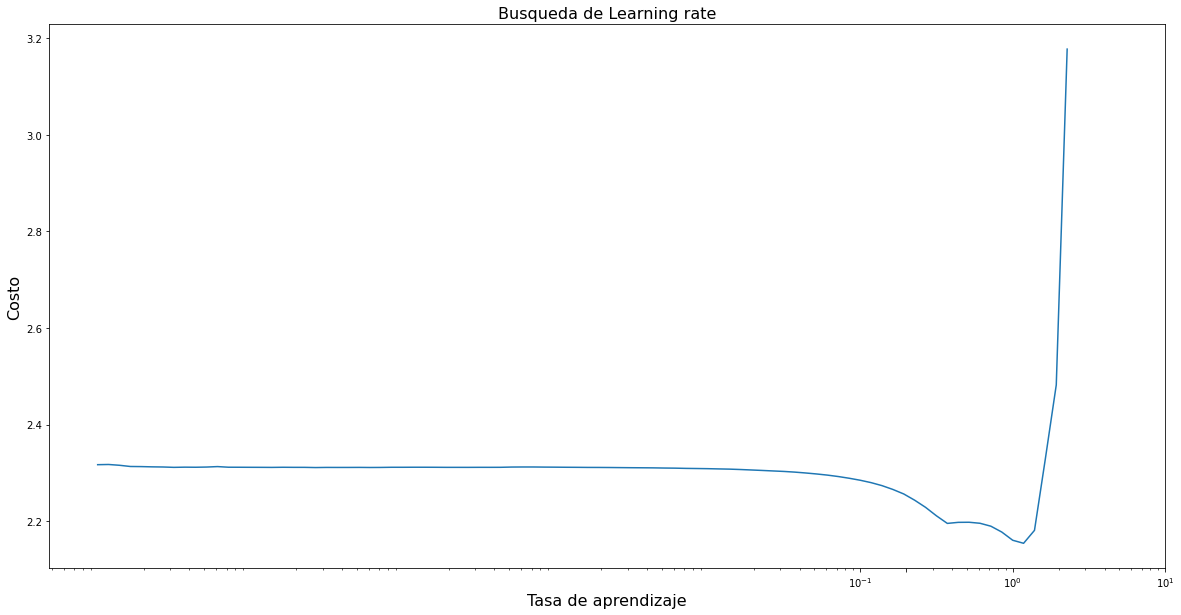

In [28]:
f1, ax1 = plt.subplots(figsize=(20,10))

fontDict = {'fontsize': 16}

ax1.plot(lg_lr[:-1], losses[:-1])
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False

ax1.set_title("Busqueda de Learning rate", fontdict= fontDict)
ax1.set_xlabel("Tasa de aprendizaje", fontdict= fontDict)
ax1.set_ylabel("Costo", fontdict= fontDict)
plt.show()

# Uncomment this if you want to see accuracie too
# f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lg_lr[:-1], accuracies[:-1])
# # ax1.plot(lg_lr, accuracies)
# ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
# ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
# plt.show()

## Tasa de aprendizaje fija

Mantiene un $\alpha$ constante durante todo el entrenamiento

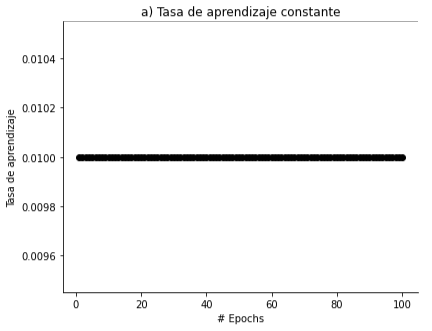

In [29]:
def Fixed():
    modelFixed = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelFixed.parameters(), lr=lr)


    start.record()
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_epochs = train(modelFixed, optimizer,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    fixed_time = start.elapsed_time(end)

    fixed_acc, fixed_cm = accuracy(modelFixed, x_test_tensor,  y_test_tensor, mb_size)

    return fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc, fixed_epochs, fixed_cm


In [30]:

resultados['fixed'] = {}
resultados['fixed']['val_acc_list'] = [0] * epochs
resultados['fixed']['test_acc'] = 0
resultados['fixed']['cost'] = [0] * epochs
resultados['fixed']['time'] = 0
resultados['fixed']['epochs'] = 0
resultados['fixed']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc, fixed_epochs, fixed_cm = Fixed()
    resultados['fixed']['val_acc_list'] = SumList(resultados['fixed']['val_acc_list'], fixed_acc_list)
    resultados['fixed']['test_acc'] += fixed_acc
    resultados['fixed']['cost'] = SumList(resultados['fixed']['cost'], fixed_cost_list)
    resultados['fixed']['time'] += fixed_time
    resultados['fixed']['epochs'] += fixed_epochs
    resultados['fixed']['cm'] += fixed_cm

#Saving results
resultados['fixed']['name'] = 'Fijo'
resultados['fixed']['lr'] = fixed_lr_list
resultados['fixed']['test_acc'] = resultados['fixed']['test_acc'] / MAX_ITERATIONS
resultados['fixed']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['fixed']['val_acc_list'], MAX_ITERATIONS))
resultados['fixed']['cost'] = DeleteZerosFromList(DivideList(resultados['fixed']['cost'], MAX_ITERATIONS))
resultados['fixed']['time'] = resultados['fixed']['time']/ MAX_ITERATIONS
resultados['fixed']['epochs'] = resultados['fixed']['epochs'] / MAX_ITERATIONS
resultados['fixed']['cm'] = resultados['fixed']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


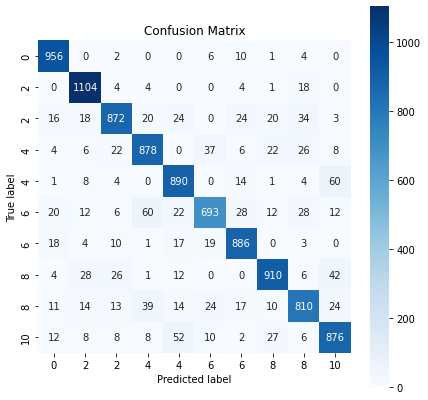

In [31]:
validate_confusion_matrix(resultados['fixed']['cm'], class_count)
plot_confusion_matrix(resultados['fixed']['cm'])

## Tasa de aprendizaje decreciente (PyTorch)

Inicia con un $\alpha$ inicial y va decreciendo en por un factor $gamma$. El decrecimiento se da un numero $l$ de epochs definidos

$\alpha: 1x10^{-2}$

$gamma: 7x10^{-1}$

$l: 10$ epochs

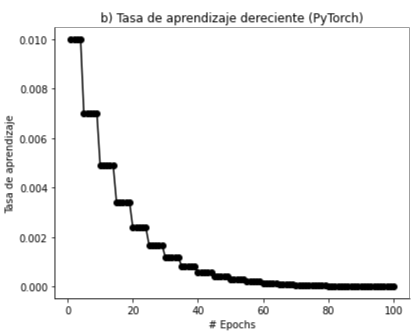

In [32]:
def Decay():
    modelDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelDecay.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7, last_epoch=-1, verbose=False)

    start.record()
    decay_acc_list, decay_cost_list, decay_lr_list, decay_epochs = train(modelDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    decay_time = start.elapsed_time(end)

    decay_acc, decay_cm = accuracy(modelDecay, x_test_tensor,  y_test_tensor, mb_size)
    
    return decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc, decay_epochs, decay_cm

In [33]:

resultados['decay'] = {}
resultados['decay']['val_acc_list'] = [0] * epochs
resultados['decay']['test_acc'] = 0
resultados['decay']['cost'] = [0] * epochs
resultados['decay']['time'] = 0
resultados['decay']['epochs'] = 0
resultados['decay']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc, decay_epochs, decay_cm = Decay()
    resultados['decay']['val_acc_list'] = SumList(resultados['decay']['val_acc_list'], decay_acc_list)
    resultados['decay']['test_acc'] += decay_acc
    resultados['decay']['cost'] = SumList(resultados['decay']['cost'], decay_cost_list)
    resultados['decay']['time'] += decay_time
    resultados['decay']['epochs'] += decay_epochs
    resultados['decay']['cm'] += decay_cm


#Saving results
resultados['decay']['name'] = 'Decreciente'
resultados['decay']['lr'] = decay_lr_list
resultados['decay']['test_acc'] = resultados['decay']['test_acc'] / MAX_ITERATIONS
resultados['decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['decay']['val_acc_list'], MAX_ITERATIONS))
resultados['decay']['cost'] = DeleteZerosFromList(DivideList(resultados['decay']['cost'], MAX_ITERATIONS))
resultados['decay']['time'] = resultados['decay']['time']/ MAX_ITERATIONS
resultados['decay']['epochs'] = resultados['decay']['epochs'] / MAX_ITERATIONS
resultados['decay']['cm'] = resultados['decay']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


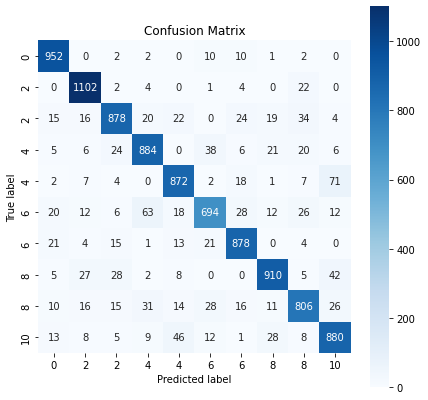

In [34]:
validate_confusion_matrix(resultados['decay']['cm'], class_count)
plot_confusion_matrix(resultados['decay']['cm'])

## Tasa de aprendizaje cíclica

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción igual a 

$$
proporción\_de\_cambio = \frac{max\_ta - base\_ta}{n}
$$

Esta implementación facilitada por PyTorch, está basada en la publicación de Tasas de aprendizaje cíclico para la red neuronal de entrenamiento (*Cyclical Learning Rates for Training Neural Networks* o por sus siglas CLR) de Leslie Smith, 2017.

$\alpha: 1x10^{-2}$

$beta: 0.9$




 

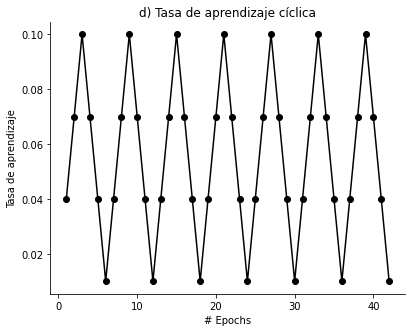

In [35]:
def Cyclic():
    modelCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelCyclic.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_epochs= train(modelCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    cyclic_time = start.elapsed_time(end)

    cyclic_acc, cyclic_cm = accuracy(modelCyclic, x_test_tensor,  y_test_tensor, mb_size)

    return cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc, cyclic_epochs, cyclic_cm

In [36]:
resultados['cyclic'] = {}
resultados['cyclic']['val_acc_list'] = [0]* epochs
resultados['cyclic']['test_acc'] = 0
resultados['cyclic']['cost'] = [0] * epochs
resultados['cyclic']['time'] = 0
resultados['cyclic']['epochs'] = 0
resultados['cyclic']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc, cyclic_epochs, cyclic_cm = Cyclic()
    resultados['cyclic']['val_acc_list'] = SumList(resultados['cyclic']['val_acc_list'], cyclic_acc_list)
    resultados['cyclic']['test_acc'] += cyclic_acc
    resultados['cyclic']['cost'] = SumList(resultados['cyclic']['cost'], cyclic_cost_list)
    resultados['cyclic']['time'] += cyclic_time
    resultados['cyclic']['epochs'] += cyclic_epochs
    resultados['cyclic']['cm'] += cyclic_cm

#Saving results
resultados['cyclic']['name'] = 'Ciclico'
resultados['cyclic']['lr'] = cyclic_lr_list
resultados['cyclic']['test_acc'] = resultados['cyclic']['test_acc'] / MAX_ITERATIONS
resultados['cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclic']['cost'], MAX_ITERATIONS))
resultados['cyclic']['time'] = resultados['cyclic']['time']/ MAX_ITERATIONS
resultados['cyclic']['epochs'] = resultados['cyclic']['epochs'] / MAX_ITERATIONS
resultados['cyclic']['cm'] = resultados['cyclic']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


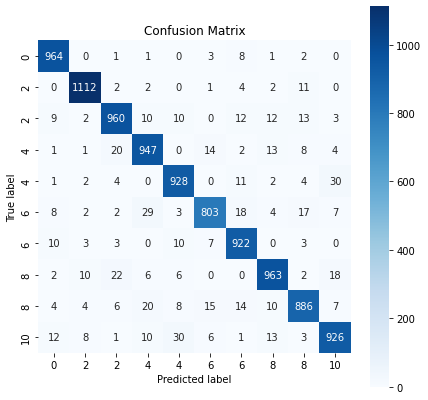

In [37]:
validate_confusion_matrix(resultados['cyclic']['cm'], class_count)
plot_confusion_matrix(resultados['cyclic']['cm'])

## Tasa de aprendizaje cíclica aleatoria (propuesta)

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción aleatoria.

$base\_ta: 1x10^{-2}$

$max\_ta: 1x10^{-1}$

$n: 3$ epochs

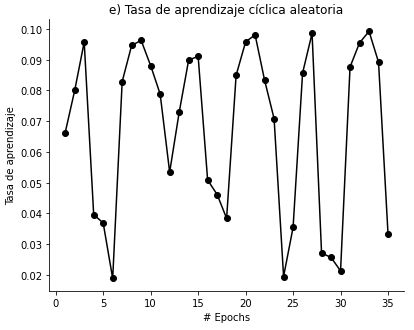

In [38]:
def CyclicGD():
    modelRandomCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic.parameters(), lr=lr)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='chipichipi')

    start.record()
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_epochs= train(modelRandomCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_time = start.elapsed_time(end)

    random_cyclic_acc, random_cyclic_cm = accuracy(modelRandomCyclic, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc, random_cyclic_epochs,random_cyclic_cm

In [39]:
resultados['random_cyclic'] = {}
resultados['random_cyclic']['val_acc_list'] = [0] * epochs
resultados['random_cyclic']['test_acc'] = 0
resultados['random_cyclic']['cost'] = [0] * epochs
resultados['random_cyclic']['time'] = 0
resultados['random_cyclic']['epochs'] = 0
resultados['random_cyclic']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc, random_cyclic_epochs, random_cyclic_cm = CyclicGD()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['val_acc_list'] = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['test_acc'] += random_cyclic_acc
    resultados['random_cyclic']['cost'] = SumList(resultados['random_cyclic']['cost'], random_cyclic_cost_list)
    resultados['random_cyclic']['time'] += random_cyclic_time
    resultados['random_cyclic']['epochs'] += random_cyclic_epochs
    resultados['random_cyclic']['cm'] += random_cyclic_cm

#Saving results
resultados['random_cyclic']['name'] = 'Random Ciclico'
resultados['random_cyclic']['lr'] = random_cyclic_lr_list
resultados['random_cyclic']['test_acc'] = resultados['random_cyclic']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['cost'], MAX_ITERATIONS))
resultados['random_cyclic']['time'] = resultados['random_cyclic']['time']/ MAX_ITERATIONS
resultados['random_cyclic']['epochs'] = resultados['random_cyclic']['epochs'] / MAX_ITERATIONS
resultados['random_cyclic']['cm'] = resultados['random_cyclic']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


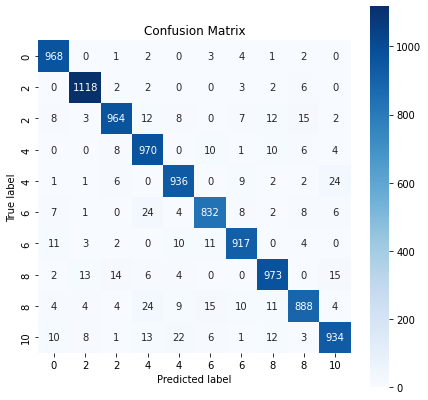

In [40]:
validate_confusion_matrix(resultados['random_cyclic']['cm'], class_count)
plot_confusion_matrix(resultados['random_cyclic']['cm'])

## Ciclico Aleatorio Decreciente

In [41]:
# def CyclicGDDecrement():
#     modelRandomCyclic_Decrement = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
#                         nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
#                         nn.Linear(in_features=layer2, out_features=10))
#     optimizer = torch.optim.SGD(modelRandomCyclic_Decrement.parameters(), lr=lr)

#     scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='decrementar_maximo')

#     start.record()
#     random_cyclic_decrement_acc_list, random_cyclic_decrement_cost_list, random_cyclic_decrement_lr_list, random_cyclic_decrement_epochs= train(modelRandomCyclic_Decrement, optimizer,scheduler, mb_size)
#     end.record()

#     torch.cuda.synchronize() 
#     random_cyclic_decrement_time = start.elapsed_time(end)

#     random_cyclic_decrement_acc = accuracy(modelRandomCyclic_Decrement, x_test_tensor,  y_test_tensor, mb_size) 

#     return random_cyclic_decrement_acc_list, random_cyclic_decrement_cost_list, random_cyclic_decrement_lr_list, random_cyclic_decrement_time, random_cyclic_decrement_acc, random_cyclic_decrement_epochs

In [42]:
# resultados['random_cyclic_decrement'] = {}
# resultados['random_cyclic_decrement']['val_acc_list'] = [0] * epochs
# resultados['random_cyclic_decrement']['test_acc'] = 0
# resultados['random_cyclic_decrement']['cost'] = [0] * epochs
# resultados['random_cyclic_decrement']['time'] = 0
# resultados['random_cyclic_decrement']['epochs'] = 0

# for _ in range(MAX_ITERATIONS):
#     random_cyclic_decrement_acc_list, random_cyclic_decrement_cost_list, random_cyclic_decrement_lr_list, random_cyclic_decrement_time, random_cyclic_decrement_acc, random_cyclic_decrement_epochs = CyclicGDDecrement()
#     a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_decrement_acc_list)
#     resultados['random_cyclic_decrement']['val_acc_list'] = SumList(resultados['random_cyclic_decrement']['val_acc_list'], random_cyclic_decrement_acc_list)
#     resultados['random_cyclic_decrement']['test_acc'] += random_cyclic_decrement_acc
#     resultados['random_cyclic_decrement']['cost'] = SumList(resultados['random_cyclic_decrement']['cost'], random_cyclic_decrement_cost_list)
#     resultados['random_cyclic_decrement']['time'] += random_cyclic_decrement_time
#     resultados['random_cyclic_decrement']['epochs'] += random_cyclic_decrement_epochs

# #Saving results
# resultados['random_cyclic_decrement']['name'] = 'Random Ciclico Decreciente'
# resultados['random_cyclic_decrement']['lr'] = random_cyclic_decrement_lr_list
# resultados['random_cyclic_decrement']['test_acc'] = resultados['random_cyclic_decrement']['test_acc'] / MAX_ITERATIONS
# resultados['random_cyclic_decrement']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_decrement']['val_acc_list'], MAX_ITERATIONS))
# resultados['random_cyclic_decrement']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_decrement']['cost'], MAX_ITERATIONS))
# resultados['random_cyclic_decrement']['time'] = resultados['random_cyclic_decrement']['time']/ MAX_ITERATIONS
# resultados['random_cyclic_decrement']['epochs'] = resultados['random_cyclic_decrement']['epochs'] / MAX_ITERATIONS

## Ciclico Aleatorio Extendido

In [43]:
def CyclicGDExtended():
    modelRandomCyclic_Extended = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic_Extended.parameters(), lr=lr)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='extendido')

    start.record()
    random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_epochs= train(modelRandomCyclic_Extended, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_extended_time = start.elapsed_time(end)

    random_cyclic_extended_acc, random_cyclic_extended_cm = accuracy(modelRandomCyclic_Extended, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_time, random_cyclic_extended_acc, random_cyclic_extended_epochs, random_cyclic_extended_cm

In [44]:
resultados['random_cyclic_extended'] = {}
resultados['random_cyclic_extended']['val_acc_list'] = [0] * epochs
resultados['random_cyclic_extended']['test_acc'] = 0
resultados['random_cyclic_extended']['cost'] = [0] * epochs
resultados['random_cyclic_extended']['time'] = 0
resultados['random_cyclic_extended']['epochs'] = 0
resultados['random_cyclic_extended']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_time, random_cyclic_extended_acc, random_cyclic_extended_epochs, random_cyclic_extended_cm = CyclicGDExtended()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_extended_acc_list)
    resultados['random_cyclic_extended']['val_acc_list'] = SumList(resultados['random_cyclic_extended']['val_acc_list'], random_cyclic_extended_acc_list)
    resultados['random_cyclic_extended']['test_acc'] += random_cyclic_extended_acc
    resultados['random_cyclic_extended']['cost'] = SumList(resultados['random_cyclic_extended']['cost'], random_cyclic_extended_cost_list)
    resultados['random_cyclic_extended']['time'] += random_cyclic_extended_time
    resultados['random_cyclic_extended']['epochs'] += random_cyclic_extended_epochs
    resultados['random_cyclic_extended']['cm'] += random_cyclic_extended_cm

#Saving results
resultados['random_cyclic_extended']['name'] = 'Random Ciclico Extended'
resultados['random_cyclic_extended']['lr'] = random_cyclic_extended_lr_list
resultados['random_cyclic_extended']['test_acc'] = resultados['random_cyclic_extended']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic_extended']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_extended']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic_extended']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_extended']['cost'], MAX_ITERATIONS))
resultados['random_cyclic_extended']['time'] = resultados['random_cyclic_extended']['time']/ MAX_ITERATIONS
resultados['random_cyclic_extended']['epochs'] = resultados['random_cyclic_extended']['epochs'] / MAX_ITERATIONS
resultados['random_cyclic_extended']['cm'] = resultados['random_cyclic_extended']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


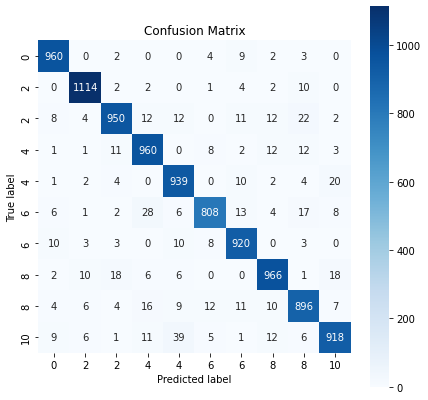

In [45]:
validate_confusion_matrix(resultados['random_cyclic_extended']['cm'], class_count)
plot_confusion_matrix(resultados['random_cyclic_extended']['cm'])

## Tasa de aprendizaje decreciente (Propuesta)

Inicia con una tasa de aprendizaje $\alpha$ inicial y posee una disminución de 0.001 cada $p$ epochs.

$\alpha: 1x10^{-2}$

$p: 1$ epochs

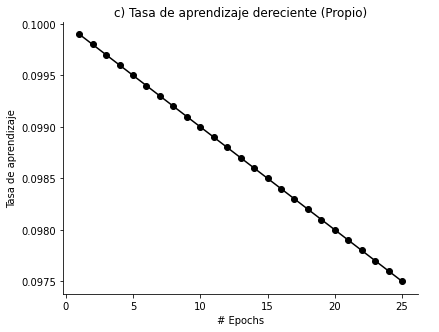

In [46]:
def Our_Decay():
    modelOurDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=lr)


    clr_fn = lambda x, y: random.uniform(x, y)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.0001, max_lr=0.1, step_size_up=1,scale_mode='decrecimiento')

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_epochs = train(modelOurDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc, our_decay_cm = accuracy(modelOurDecay, x_test_tensor,  y_test_tensor, mb_size)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs, our_decay_cm

In [47]:
resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0
resultados['our_decay']['epochs'] = 0
resultados['our_decay']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs, our_decay_cm = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time
    resultados['our_decay']['epochs'] += our_decay_epochs
    resultados['our_decay']['cm'] += our_decay_cm

#Saving results
resultados['our_decay']['name'] = 'Our Decay'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] / MAX_ITERATIONS
resultados['our_decay']['epochs'] = resultados['our_decay']['epochs'] / MAX_ITERATIONS
resultados['our_decay']['cm'] = resultados['our_decay']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


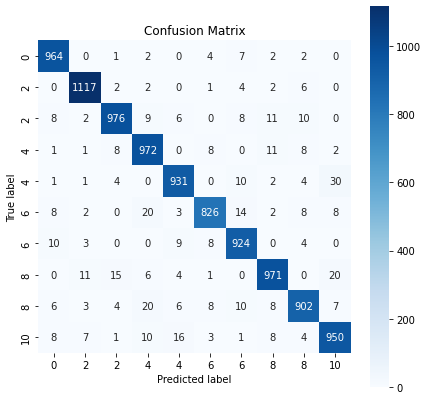

In [48]:
validate_confusion_matrix(resultados['our_decay']['cm'], class_count)
plot_confusion_matrix(resultados['our_decay']['cm'])

## L-BFGS

Derivado del método BFGS pero con memoria limitada. Considera información de las $h$ iteraciones previas

$\alpha: 1$

$h: 10$ iteraciones

In [49]:
def LBFGS():
    modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                max_iter=1, #maximal number of iterations per optimization step
                                )

    lbfgs_cost_list = [0.0]
    lbfgs_acc_list = [0.0]
    modelLBFGS = modelLBFGS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0
    unregistered = True
    iter_found = 0
    iteraciones_lbfgs = 0
    start.record()
    #training
    while (i < 100):
        if(lbfgs_acc_list[-1] >= 0.95 and unregistered):
          iter_found = i
          unregistered = False
        #print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            # print(f'costo: {cost.item()}')
            return cost
        iteraciones_lbfgs += 1
        cost = optimizer.step(closure)
        lbfgs_cost_list.append(cost.item())
        lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size)[0])
        #print(f'accuracy: {lbfgs_acc_list[-1]}')
        i+=1
    end.record()

    torch.cuda.synchronize()
    lbfgs_time = start.elapsed_time(end)

    lbfgs_acc, lbfgs_cm = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_acc_list, lbfgs_cost_list, [0] ,lbfgs_time, lbfgs_acc, iter_found, iteraciones_lbfgs, lbfgs_cm

In [50]:
resultados['lbfgs'] = {}
resultados['lbfgs']['val_acc_list'] = [0] * epochs
resultados['lbfgs']['test_acc'] = 0
resultados['lbfgs']['cost'] = [0] * epochs
resultados['lbfgs']['time'] = 0
resultados['lbfgs']['epochs'] = 0
resultados['lbfgs']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    lbfgs_acc_list, lbfgs_cost_list, lbfgs_lr_list, lbfgs_time, lbfgs_acc, lbfgs_epochs, iteraciones_lbfgs, lbfgs_cm = LBFGS()
    resultados['lbfgs']['val_acc_list'] = SumList(resultados['lbfgs']['val_acc_list'], lbfgs_acc_list)
    resultados['lbfgs']['test_acc'] += lbfgs_acc
    resultados['lbfgs']['cost'] = SumList(resultados['lbfgs']['cost'], lbfgs_cost_list)
    resultados['lbfgs']['time'] += lbfgs_time
    resultados['lbfgs']['epochs'] += lbfgs_epochs
    resultados['lbfgs']['cm'] += lbfgs_cm

#Saving results
resultados['lbfgs']['name'] = 'LBFGS'
resultados['lbfgs']['lr'] = lbfgs_lr_list
resultados['lbfgs']['test_acc'] = resultados['lbfgs']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['cost'], MAX_ITERATIONS))
resultados['lbfgs']['time'] = resultados['lbfgs']['time'] / MAX_ITERATIONS
resultados['lbfgs']['epochs'] = resultados['lbfgs']['epochs'] / MAX_ITERATIONS
resultados['lbfgs']['cm'] = resultados['lbfgs']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


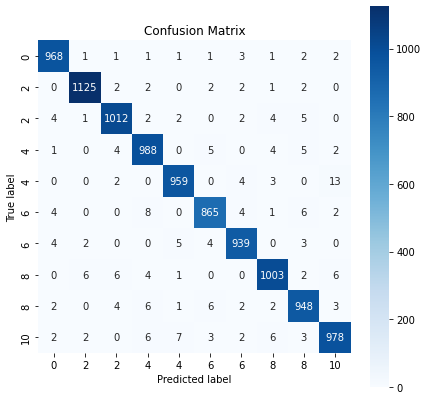

In [51]:
validate_confusion_matrix(resultados['lbfgs']['cm'], class_count)
plot_confusion_matrix(resultados['lbfgs']['cm'])

## L-BFGS con búsqueda lineal

Posee la misma implementación del método L-BFGS con la diferencia de que se agregan *las condiciones fuertes de Wolfe*

In [52]:
def LBFGS_LS():
    modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                                #max_iter=1,
                                line_search_fn="strong_wolfe"
                                )

    lbfgs_ls_cost_list = [0.0]
    lbfgs_ls_acc_list = [0.0]
    modelLBFGS_LS = modelLBFGS_LS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0
    iter_found = 0
    unregistered = True
    iteraciones_lbfgs_ls = []
    start.record()
    #training
    while (i < 100):
        if(lbfgs_ls_acc_list[-1] >= 0.95 and unregistered):
            iter_found = i
            unregistered = False
        # print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS_LS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            # print(f'costo: {cost.item()}')  
            iteraciones_lbfgs_ls.append('0')
            return cost
        lbfgs_ls_cost_list.append(optimizer.step(closure).item())
        lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size)[0])
        i+=1
            
    #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
    end.record()

    torch.cuda.synchronize()
    lbfgs_ls_time = start.elapsed_time(end)

    lbfgs_ls_acc, lbfgs_ls_cm = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_ls_acc_list, lbfgs_ls_cost_list, [0] ,lbfgs_ls_time, lbfgs_ls_acc, iter_found, iteraciones_lbfgs_ls, lbfgs_ls_cm

In [53]:
resultados['lbfgs_ls'] = {}
resultados['lbfgs_ls']['val_acc_list'] = [0] * epochs
resultados['lbfgs_ls']['test_acc'] = 0
resultados['lbfgs_ls']['cost'] = [0] * epochs
resultados['lbfgs_ls']['time'] = 0
resultados['lbfgs_ls']['epochs'] = 0
resultados['lbfgs_ls']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    lbfgs_ls_acc_list, lbfgs_ls_cost_list, lbfgs_ls_lr_list ,lbfgs_ls_time, lbfgs_ls_acc, lbfgs_ls_epochs, iteraciones_lbfgs_ls, lbfgs_ls_cm = LBFGS_LS()
    resultados['lbfgs_ls']['val_acc_list'] = SumList(resultados['lbfgs_ls']['val_acc_list'], lbfgs_ls_acc_list)
    resultados['lbfgs_ls']['test_acc'] += lbfgs_ls_acc
    resultados['lbfgs_ls']['cost'] = SumList(resultados['lbfgs_ls']['cost'], lbfgs_ls_cost_list)
    resultados['lbfgs_ls']['time'] += lbfgs_ls_time
    resultados['lbfgs_ls']['epochs'] += lbfgs_ls_epochs
    resultados['lbfgs_ls']['cm'] += lbfgs_ls_cm

#Saving results
resultados['lbfgs_ls']['name'] = 'LBFGS With LS'
resultados['lbfgs_ls']['lr'] = lbfgs_ls_lr_list
resultados['lbfgs_ls']['test_acc'] = resultados['lbfgs_ls']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs_ls']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs_ls']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['cost'], MAX_ITERATIONS))
resultados['lbfgs_ls']['time'] = resultados['lbfgs_ls']['time'] / MAX_ITERATIONS
resultados['lbfgs_ls']['epochs'] = resultados['lbfgs_ls']['epochs'] / MAX_ITERATIONS
resultados['lbfgs_ls']['cm'] = resultados['lbfgs_ls']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


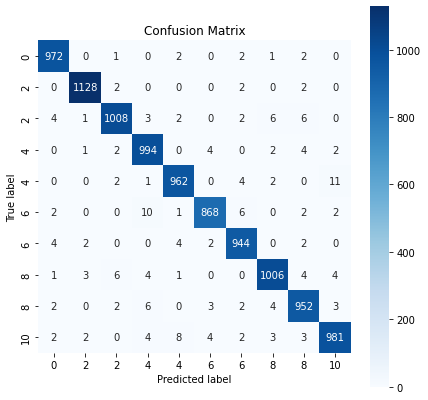

In [54]:
validate_confusion_matrix(resultados['lbfgs_ls']['cm'], class_count)
plot_confusion_matrix(resultados['lbfgs_ls']['cm'])

## Adam

$\alpha: 1x10^{-2}$ 

$beta1: 0.9$

$beta2: 0.999$

In [55]:
def Adam():
    modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list, adam_epochs = train(modelAdam,optimiserAdam,None, mb_size)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc, adam_cm = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs, adam_cm

In [56]:

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0
resultados['adam']['epochs'] = 0
resultados['adam']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))


for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs, adam_cm = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time
    resultados['adam']['epochs'] += adam_epochs
    resultados['adam']['cm'] += adam_cm

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time'] / MAX_ITERATIONS
resultados['adam']['epochs'] = resultados['adam']['epochs'] / MAX_ITERATIONS
resultados['adam']['cm'] = resultados['adam']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


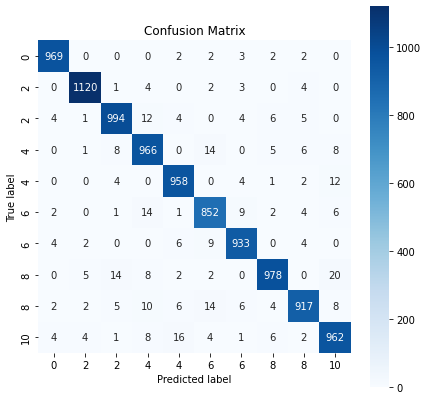

In [57]:
validate_confusion_matrix(resultados['adam']['cm'], class_count)
plot_confusion_matrix(resultados['adam']['cm'])

## Momentum

Se utiliza una optimización por el descenso del gradiente estocástico empleando Momentum.

$beta: 0.9$

In [58]:
def SGDM():
    modelSGDM = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)
    start.record()
    SGDM_acc_list, SGDM_cost_list,SGDM_lr_list, SGDM_epochs = train(modelSGDM, optimiserSGDM,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    SGDM_time = start.elapsed_time(end)

    SGDM_acc, SGDM_cm = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

    return SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc, SGDM_epochs, SGDM_cm

In [59]:
resultados['SGDM'] = {}
resultados['SGDM']['val_acc_list'] = [0] * epochs
resultados['SGDM']['test_acc'] = 0
resultados['SGDM']['cost'] = [0] * epochs
resultados['SGDM']['time'] = 0
resultados['SGDM']['epochs'] = 0
resultados['SGDM']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc, SGDM_epochs, SGDM_cm = SGDM()
    resultados['SGDM']['val_acc_list'] = SumList(resultados['SGDM']['val_acc_list'], SGDM_acc_list)
    resultados['SGDM']['test_acc'] += SGDM_acc
    resultados['SGDM']['cost'] = SumList(resultados['SGDM']['cost'], SGDM_cost_list)
    resultados['SGDM']['time'] += SGDM_time
    resultados['SGDM']['epochs'] += SGDM_epochs
    resultados['SGDM']['cm'] += SGDM_cm

#Saving results
resultados['SGDM']['name'] = 'SGDM'
resultados['SGDM']['lr'] = SGDM_lr_list
resultados['SGDM']['test_acc'] = resultados['SGDM']['test_acc'] / MAX_ITERATIONS
resultados['SGDM']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['SGDM']['val_acc_list'], MAX_ITERATIONS))
resultados['SGDM']['cost'] = DeleteZerosFromList(DivideList(resultados['SGDM']['cost'], MAX_ITERATIONS))
resultados['SGDM']['time'] = resultados['SGDM']['time'] / MAX_ITERATIONS
resultados['SGDM']['epochs'] = resultados['SGDM']['epochs'] / MAX_ITERATIONS
resultados['SGDM']['cm'] = resultados['SGDM']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


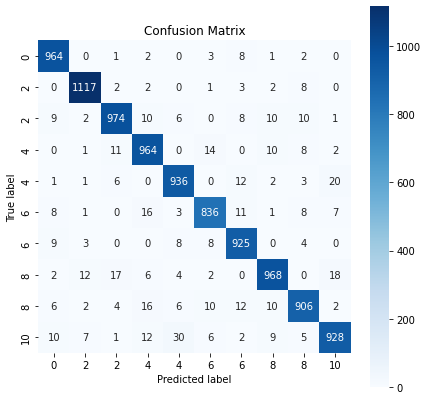

In [60]:
validate_confusion_matrix(resultados['SGDM']['cm'], class_count)
plot_confusion_matrix(resultados['SGDM']['cm'])

## RMSProp

$\alpha: 1x10^{-2}$ 

$beta: 0.9$


In [61]:
def RMSP():
    modelRMSP = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)
    start.record()
    RMSP_acc_list, RMSP_cost_list,RMSP_lr_list, RMSP_epochs = train(modelRMSP, optimiserRMSP,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    RMSP_time = start.elapsed_time(end)

    RMSP_acc, RMSP_cm = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

    return RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc, RMSP_epochs, RMSP_cm

In [62]:
resultados['RMSP'] = {}
resultados['RMSP']['val_acc_list'] = [0] * epochs
resultados['RMSP']['test_acc'] = 0
resultados['RMSP']['cost'] = [0] * epochs
resultados['RMSP']['time'] = 0
resultados['RMSP']['epochs'] = 0
resultados['RMSP']['cm'] = np.zeros((NUM_CLASSES, NUM_CLASSES))

for _ in range(MAX_ITERATIONS):
    RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc, RMSP_epochs, RMSP_cm = SGDM()
    resultados['RMSP']['val_acc_list'] = SumList(resultados['RMSP']['val_acc_list'], RMSP_acc_list)
    resultados['RMSP']['test_acc'] += RMSP_acc
    resultados['RMSP']['cost'] = SumList(resultados['RMSP']['cost'], RMSP_cost_list)
    resultados['RMSP']['time'] += RMSP_time
    resultados['RMSP']['epochs'] += RMSP_epochs
    resultados['RMSP']['cm'] += RMSP_cm

#Saving results
resultados['RMSP']['name'] = 'RMSP'
resultados['RMSP']['lr'] = RMSP_lr_list
resultados['RMSP']['test_acc'] = resultados['RMSP']['test_acc'] / MAX_ITERATIONS
resultados['RMSP']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['RMSP']['val_acc_list'], MAX_ITERATIONS))
resultados['RMSP']['cost'] = DeleteZerosFromList(DivideList(resultados['RMSP']['cost'], MAX_ITERATIONS))
resultados['RMSP']['time'] = resultados['RMSP']['time'] / MAX_ITERATIONS
resultados['RMSP']['epochs'] = resultados['RMSP']['epochs'] / MAX_ITERATIONS
resultados['RMSP']['cm'] = resultados['RMSP']['cm'] / MAX_ITERATIONS

La matriz de confusión es válida


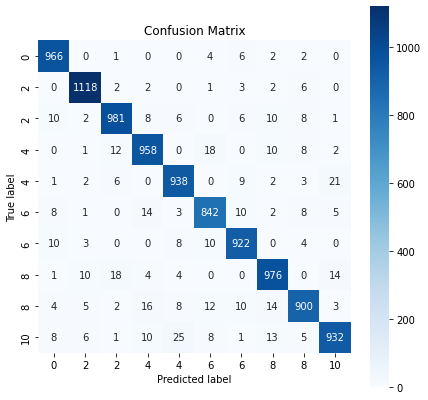

In [63]:
validate_confusion_matrix(resultados['RMSP']['cm'], class_count)
plot_confusion_matrix(resultados['RMSP']['cm'])

# Resultados

Al guardar todos los resultados de cada método en sus respectivos diccionarios, se procede a crear un dataframe con estos resultados. Adicionalmente, se generan nuevas columnas derivadas de datos que ya disponemos y se hacen tratamiento de formato para su análisis.

In [64]:
for key, _ in resultados.items():
    if( resultados[key]['val_acc_list'][0] == 0 ):
        continue
    resultados[key]['val_acc_list'].insert(0,0)

In [65]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
# resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
# resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

### L-BFGS vs L-BFGS con búsqueda lineal

Comparación de número de veces que se procesa el conjunto de datos de pruebas completo

In [66]:
print(f'L-BFGS: {iteraciones_lbfgs}, L-BFGS con búsqueda:{len(iteraciones_lbfgs_ls)}')

L-BFGS: 100, L-BFGS con búsqueda:207


### Comportamiento de las trazas de aprendizaje no adaptativas

C:\Users\denis\AppData\Local\Temp\ipykernel_30816\1365830555.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


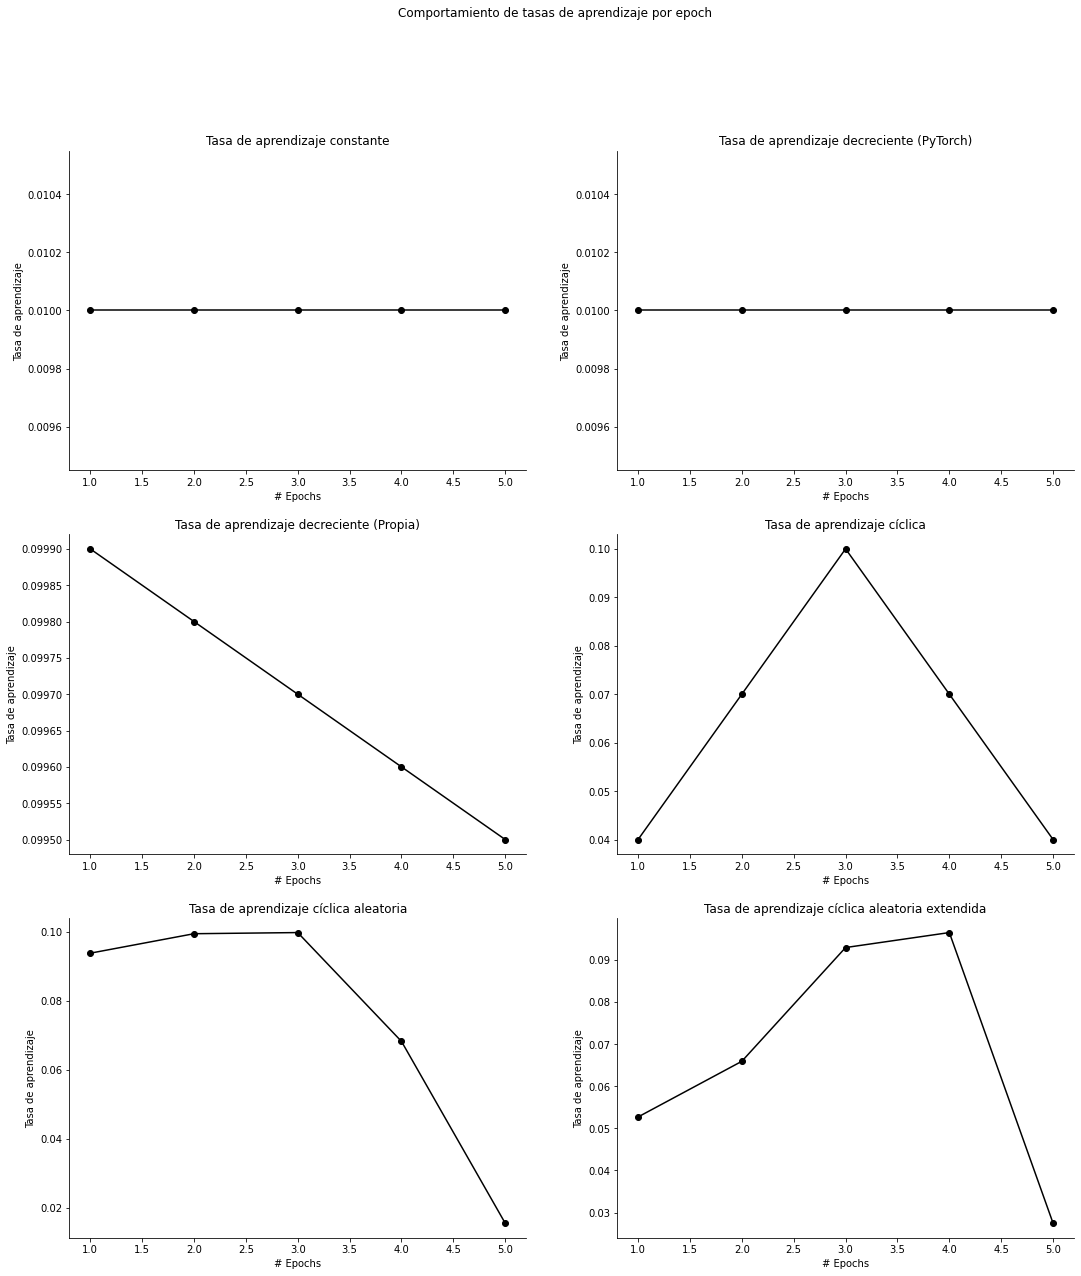

In [68]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(3,2,figsize=(18, 20))
# method = [fixed_lr_list, decay_lr_list, our_decay_lr_list,cyclic_lr_list, random_cyclic_lr_list]

method = [fixed_lr_list, 
          decay_lr_list, 
          our_decay_lr_list,  
          cyclic_lr_list, 
          random_cyclic_lr_list,
          random_cyclic_extended_lr_list]

names = ['Tasa de aprendizaje constante', 
         'Tasa de aprendizaje decreciente (PyTorch)',
         'Tasa de aprendizaje decreciente (Propia)',
         'Tasa de aprendizaje cíclica',
         'Tasa de aprendizaje cíclica aleatoria',
         'Tasa de aprendizaje cíclica aleatoria extendida']
i = 0
for a in range(3):
    for b in range(2):
        if i == len(method):
            ax[a,b].spines['top'].set_visible(False)
            ax[a,b].spines['right'].set_visible(False)
            ax[a,b].spines['bottom'].set_visible(False)
            ax[a,b].spines['left'].set_visible(False)
            plt.axis('off')
            break
        if len(method[i]) > 1:
            ax[a,b].plot(range(1, len(method[i])), 
                    method[i][1:], 
                    'black',
                    marker = 'o')
        else:
            ax[a,b].plot(range(len(method[i])), 
                    method[i], 
                    'black',
                    marker = 'o')
        ax[a,b].set_xlabel('# Epochs') #, fontsize = 18)
        ax[a,b].set_ylabel('Tasa de aprendizaje') #, fontsize = 18)
        ax[a,b].spines['top'].set_visible(False)
        ax[a,b].spines['right'].set_visible(False)
        ax[a,b].set_title(names[i])
        i += 1


fig.suptitle('Comportamiento de tasas de aprendizaje por epoch')
fig.show()

### Velocidad de convergencia basado en epochs

In [ ]:
resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

In [ ]:
resultados_df[['name','epochs','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_28432\1767391596.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','epochs','time']].style.hide_index()


name,epochs,time
LBFGS With LS,2.000000,10205.296419
Adam,4.400000,43585.478906
SGDM,7.666667,33806.863542
Our Decay,8.133333,30683.612630
RMSP,8.133333,35461.420052
Random Ciclico Extended,9.733333,30732.632552
Random Ciclico,9.866667,30889.574609
Random Ciclico Decreciente,11.933333,30758.719010
Ciclico,12.466667,30630.496484
Decreciente,16.333333,31860.561719


### Curvas de aprendizaje: precisión

In [ ]:
resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)
resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_28432\4194298493.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()


name,val_acc,time,test_acc,epochs
Random Ciclico Decreciente,98.53%,30758.719010,98.58%,11.933333
RMSP,98.24%,35461.420052,98.5%,8.133333
LBFGS With LS,97.89%,10205.296419,98.36%,2.000000
Random Ciclico Extended,98.09%,30732.632552,98.36%,9.733333
Random Ciclico,98.45%,30889.574609,98.33%,9.866667
SGDM,98.35%,33806.863542,98.31%,7.666667
Ciclico,98.16%,30630.496484,98.31%,12.466667
LBFGS,97.97%,4638.280599,97.98%,34.866667
Our Decay,98.26%,30683.612630,97.93%,8.133333
Adam,96.97%,43585.478906,96.85%,4.400000


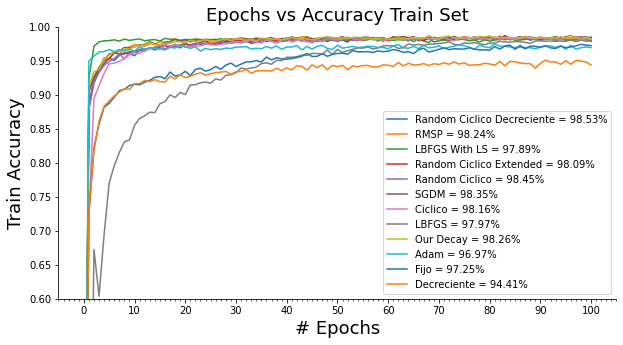

In [ ]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.6, 1])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

### Curvas de aprendizaje: pérdida en la función de costo

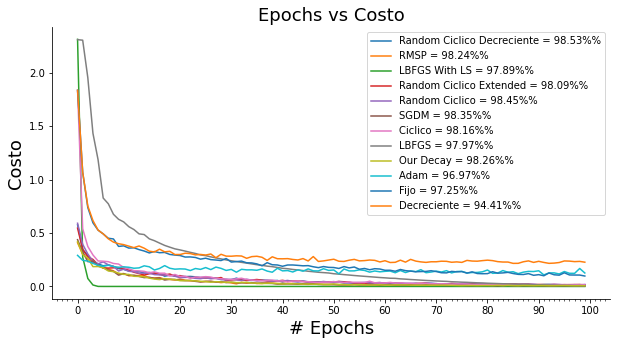

In [ ]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = resultados_df.loc[k1,'val_acc']))

plt.title('Epochs vs Costo', fontsize = 18)


ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

In [ ]:
from datetime import datetime
import os.path

#Get time
now = datetime.now()
#Format DateTime
date_time = now.strftime("%m_%d_%Y-%H_%M")

#Create Path for save Results
file_name = os.path.join('Resultados_Experimento_1', f'Experimento1[{date_time}].xlsx')

resultados_df.to_excel(file_name, index = False)